In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
print("librosa: %s" % librosa.__version__)

2023-02-24 07:41:43.073399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 07:41:43.155493: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 07:41:43.591390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-24 07:41:43.591468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

tensorflow: 2.11.0
librosa: 0.10.0


/root/miniconda3/envs/tf-py38/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# Function that converts the user-created audio to the format that the model 
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [3]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
# uploaded_file_name = '/root/ws/ml/videos/rachel-last-night-working-here/scene-audio.mp3'
# uploaded_file_name = '/tmp/audiod00c40c5e11de3ecc94e6d0cf47421154a61042d-0-100.wav'
# uploaded_file_name = '/tmp/audiod366c9163dd942266b4bc2553d6852f7993e6162-0-100.wav'
uploaded_file_name = '/tmp/audioc28845dd1fae4617f7395509b5a4dfcfb694f2b2-0-100.wav'
converted_audio_file = convert_audio_for_model(uploaded_file_name)
converted_audio_file

'converted_audio_file.wav'

In [4]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 5.22s
Size of the input: 83520


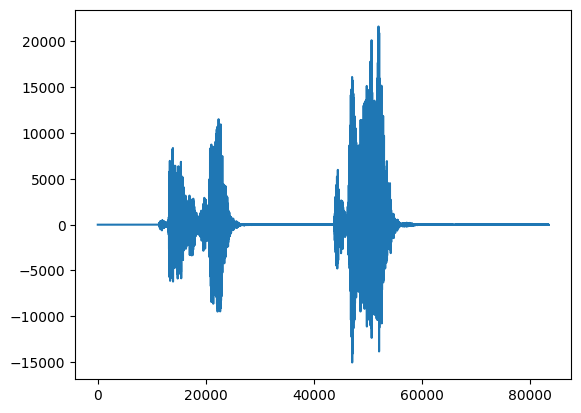

In [5]:
_ = plt.plot(audio_samples)

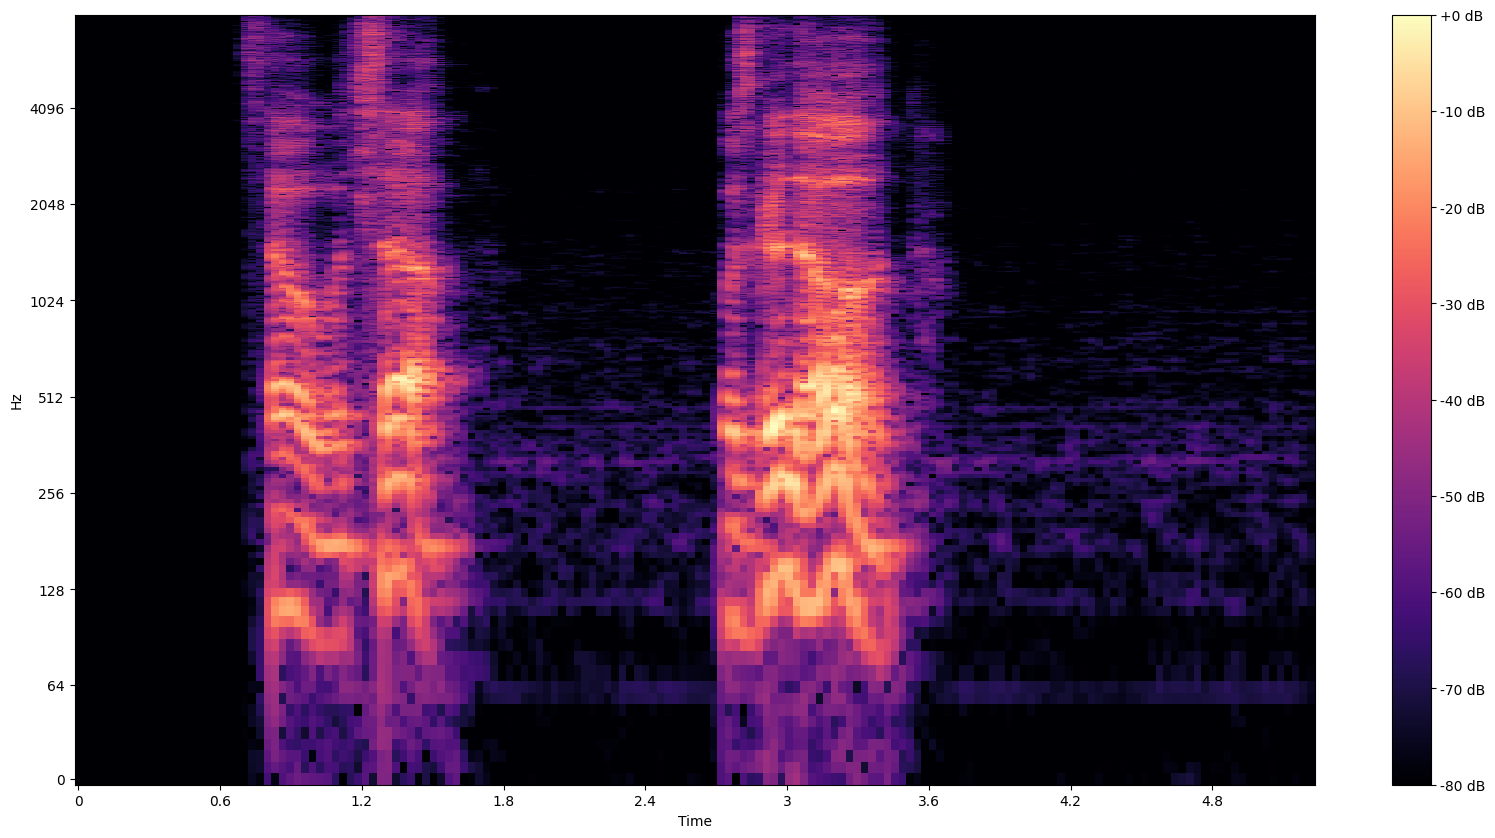

In [6]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log', 
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', x_axis='time', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()

audio_samples = audio_samples / float(MAX_ABS_INT16)

In [7]:
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

2023-02-24 07:41:45.699006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-24 07:41:45.729920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-24 07:41:45.730240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-24 07:41:45.730622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

2023-02-24 07:41:56.980015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-02-24 07:41:58.300862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


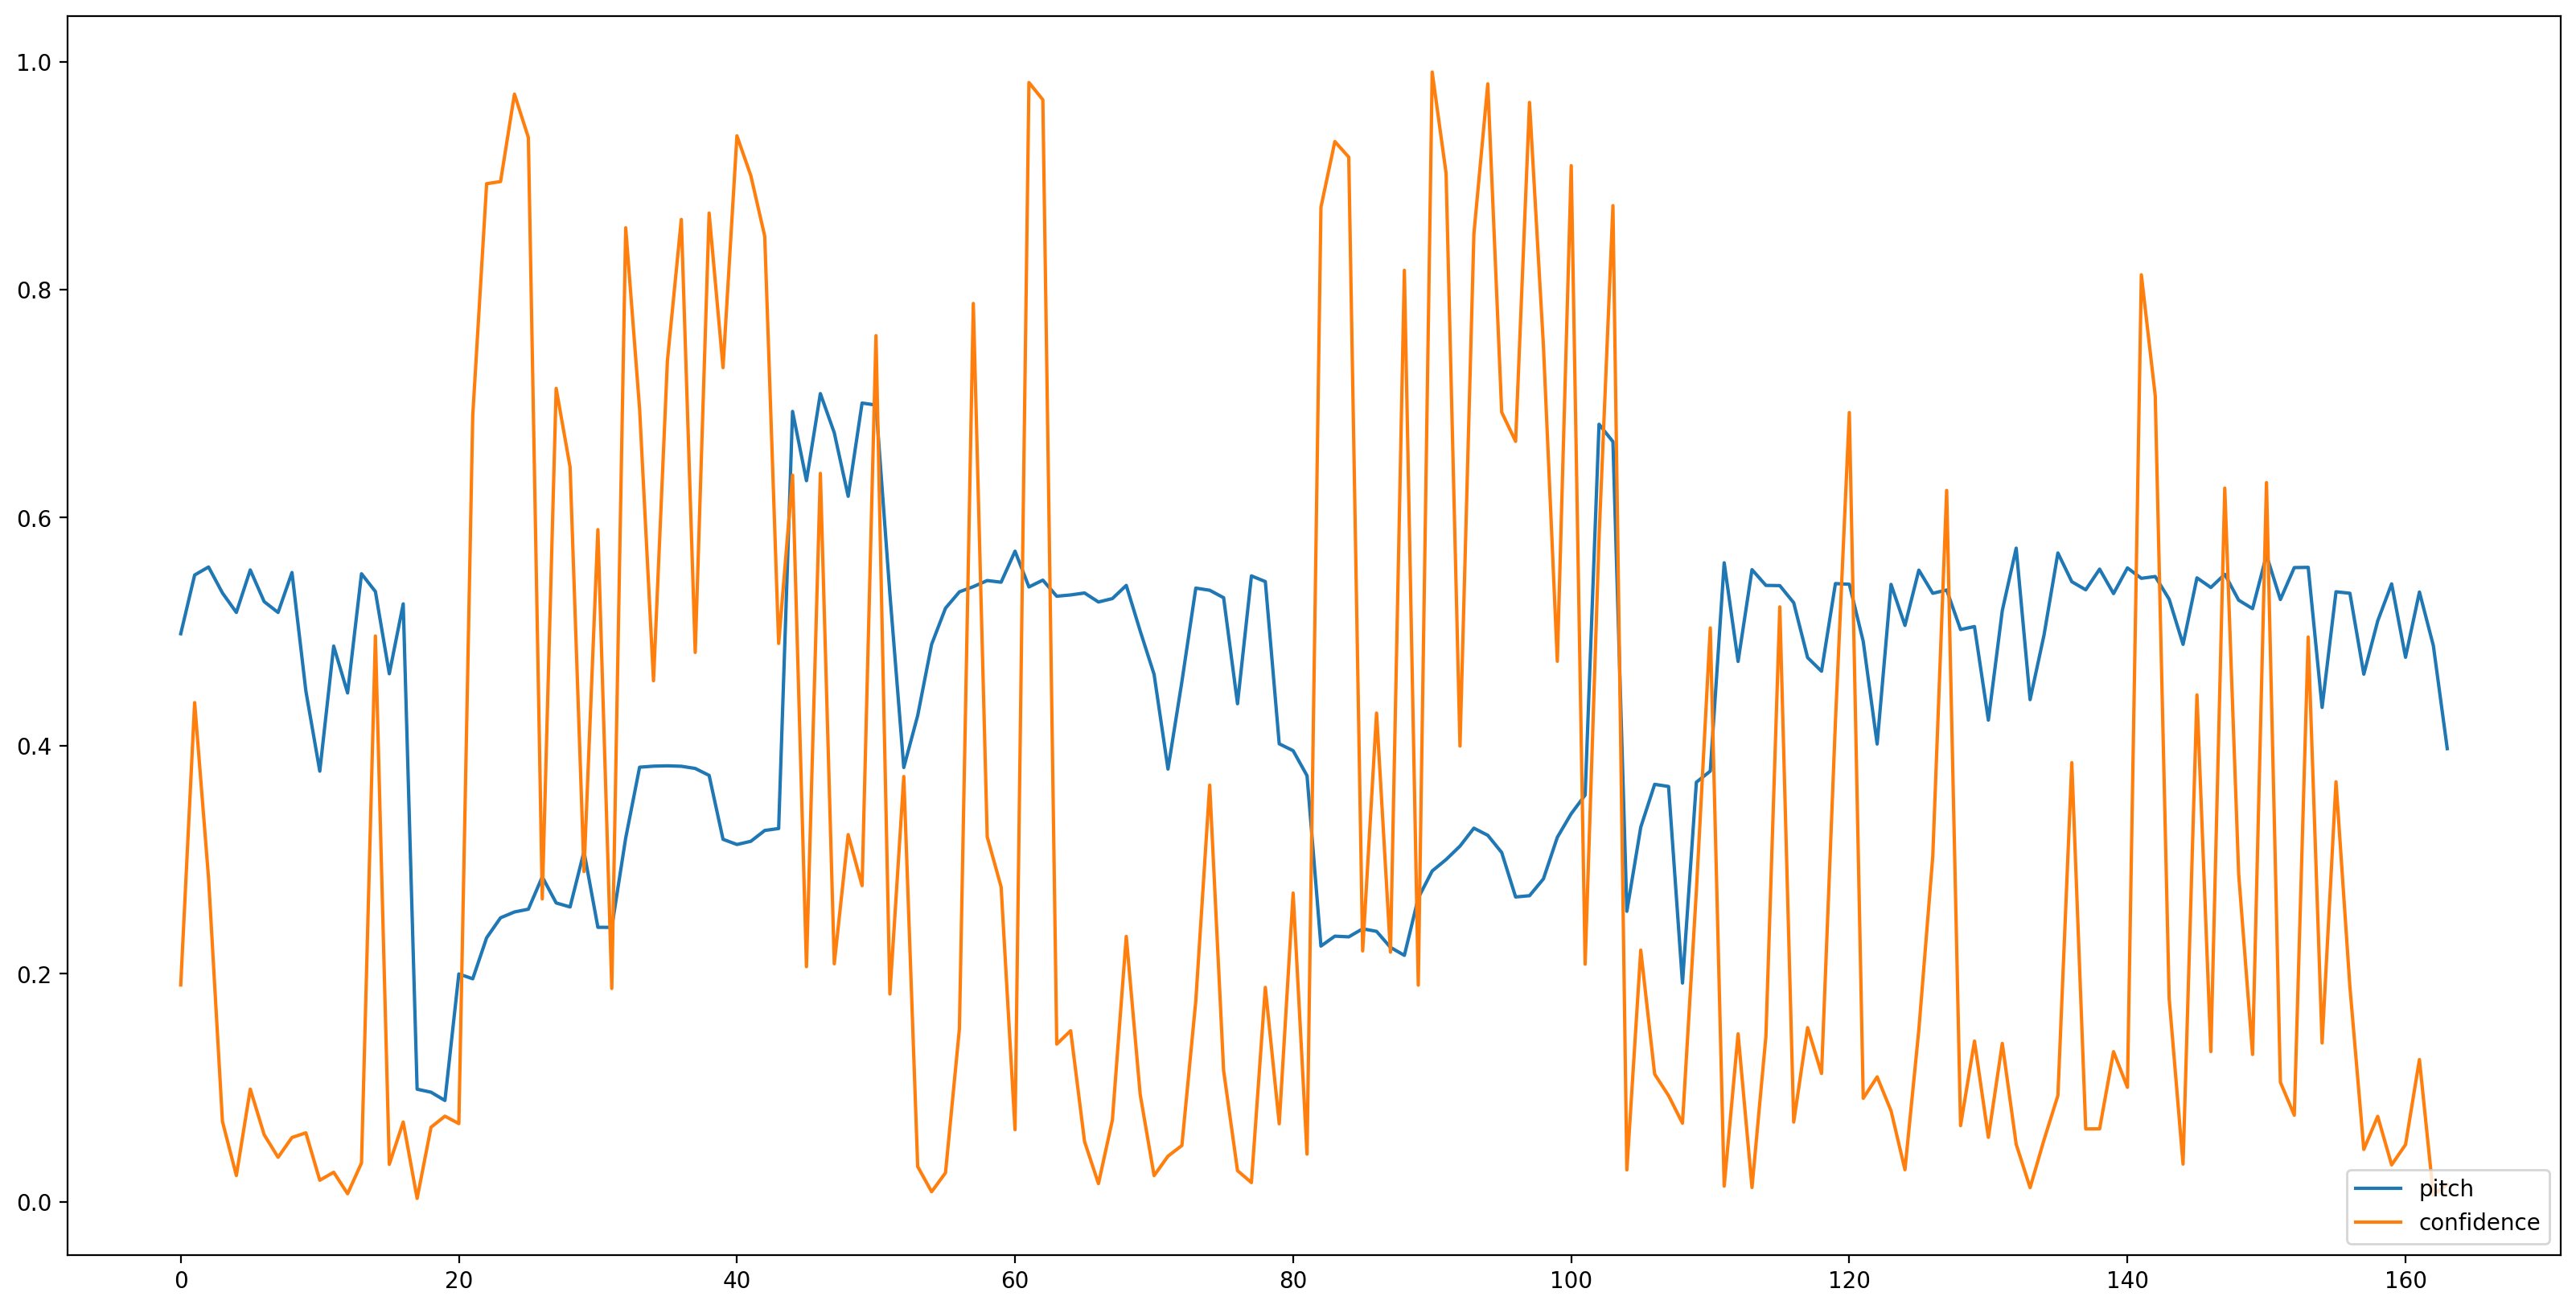

In [8]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()


In [9]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
print(indices)
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.7  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
print(confident_pitch_outputs_x)

print(model)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 10)
# ax.set_ylim([0, 1])
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

# plt.show()

range(0, 164)
(22, 23, 24, 25, 27, 32, 35, 36, 38, 39, 40, 41, 42, 50, 57, 61, 62, 82, 83, 84, 88, 90, 91, 93, 94, 97, 98, 100, 103, 141, 142)


(22, 23, 24, 25, 27, 32, 35, 36, 38, 39, 40, 41, 42, 50, 57, 61, 62, 82, 83, 84, 88, 90, 91, 93, 94, 97, 98, 100, 103, 141, 142)
0.03193548387096774
510.9677419354839
0.03125
[0.6875, 0.71875, 0.75, 0.78125, 0.84375, 1.0, 1.09375, 1.125, 1.1875, 1.21875, 1.25, 1.28125, 1.3125, 1.5625, 1.78125, 1.90625, 1.9375, 2.5625, 2.59375, 2.625, 2.75, 2.8125, 2.84375, 2.90625, 2.9375, 3.03125, 3.0625, 3.125, 3.21875, 4.40625, 4.4375]
[{'x': 22, 'time': 0.6875, 'y': 0.23146821558475494}, {'x': 23, 'time': 0.71875, 'y': 0.24898472428321838}, {'x': 24, 'time': 0.75, 'y': 0.25408032536506653}, {'x': 25, 'time': 0.78125, 'y': 0.2565239667892456}, {'x': 27, 'time': 0.84375, 'y': 0.26200026273727417}, {'x': 32, 'time': 1.0, 'y': 0.318950891494751}, {'x': 35, 'time': 1.09375, 'y': 0.38228172063827515}, {'x': 36, 'time': 1.125, 'y': 0.3818909823894501}, {'x': 38, 'time': 1.1875, 'y': 0.3739002048969269}, {'x': 39, 'time': 1.21875, 'y': 0.317818820476532}, {'x': 40, 'time': 1.25, 'y': 0.3132741153240204}, {

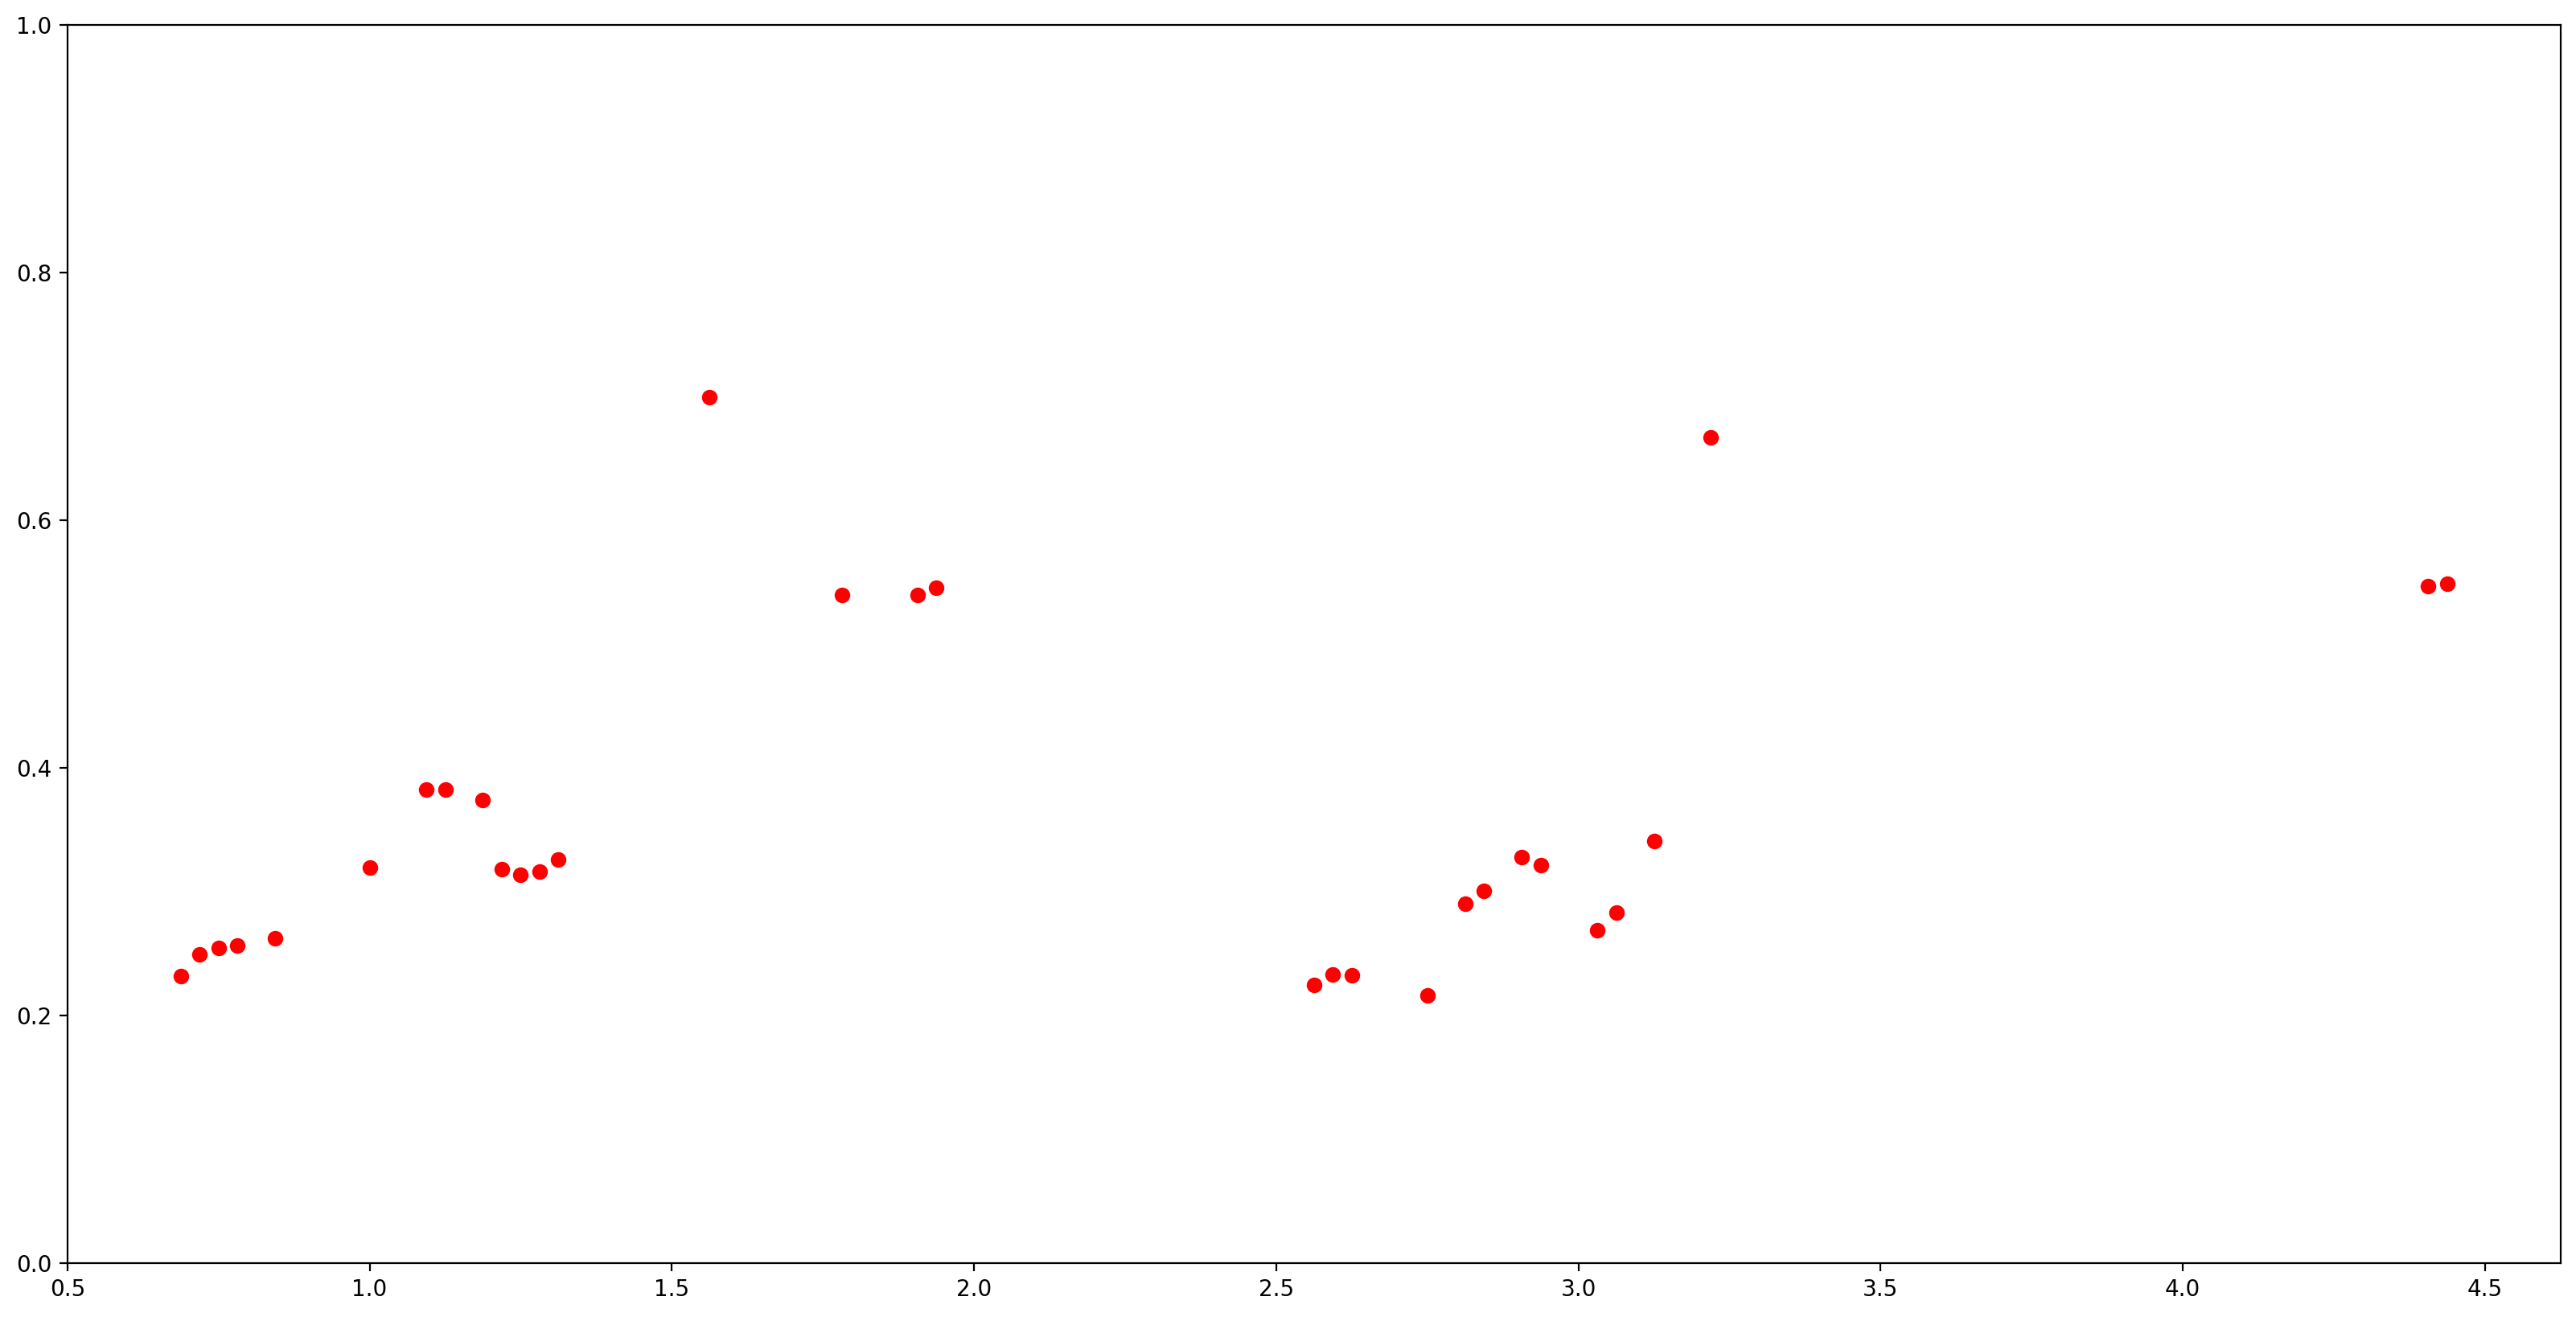

In [10]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.7  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

print(confident_pitch_outputs_x)

# n_fft = 2048

time_offset = 1.98 / 62
print(time_offset)
# time_offset = inputs_to_logits_ratio / 16000
inputs_to_logits_ratio = time_offset * 16000
print(inputs_to_logits_ratio)

inputs_to_logits_ratio = 500
time_offset = inputs_to_logits_ratio / 16000
print(time_offset)

offsets = [
    {
        "x": x,
        "time": x * time_offset,
        "y": y,
        # "start_time": round(d["start_offset"] * time_offset, 2),
        # "end_time": round(d["end_offset"] * time_offset, 2),
    }
    for x, y in zip(confident_pitch_outputs_x, confident_pitch_outputs_y)
]

confident_pitch_outputs_ts = [ x * time_offset for x in confident_pitch_outputs_x ]
print(confident_pitch_outputs_ts)

plt.scatter(confident_pitch_outputs_ts, confident_pitch_outputs_y, c="r")

print(offsets)

plt.show()

In [11]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
print(indices)
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.7  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
print(confident_pitch_outputs_x)

print(model)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 10)
# ax.set_ylim([0, 1])
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

# plt.show()

range(0, 164)
(22, 23, 24, 25, 27, 32, 35, 36, 38, 39, 40, 41, 42, 50, 57, 61, 62, 82, 83, 84, 88, 90, 91, 93, 94, 97, 98, 100, 103, 141, 142)


In [12]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
print(indices)
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.7  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
print(confident_pitch_outputs_x)

print(model)

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 10)
# ax.set_ylim([0, 1])
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
# plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

# plt.show()

range(0, 164)
(22, 23, 24, 25, 27, 32, 35, 36, 38, 39, 40, 41, 42, 50, 57, 61, 62, 82, 83, 84, 88, 90, 91, 93, 94, 97, 98, 100, 103, 141, 142)


[0.         0.         0.         ... 0.00030518 0.00015259 0.00012207]


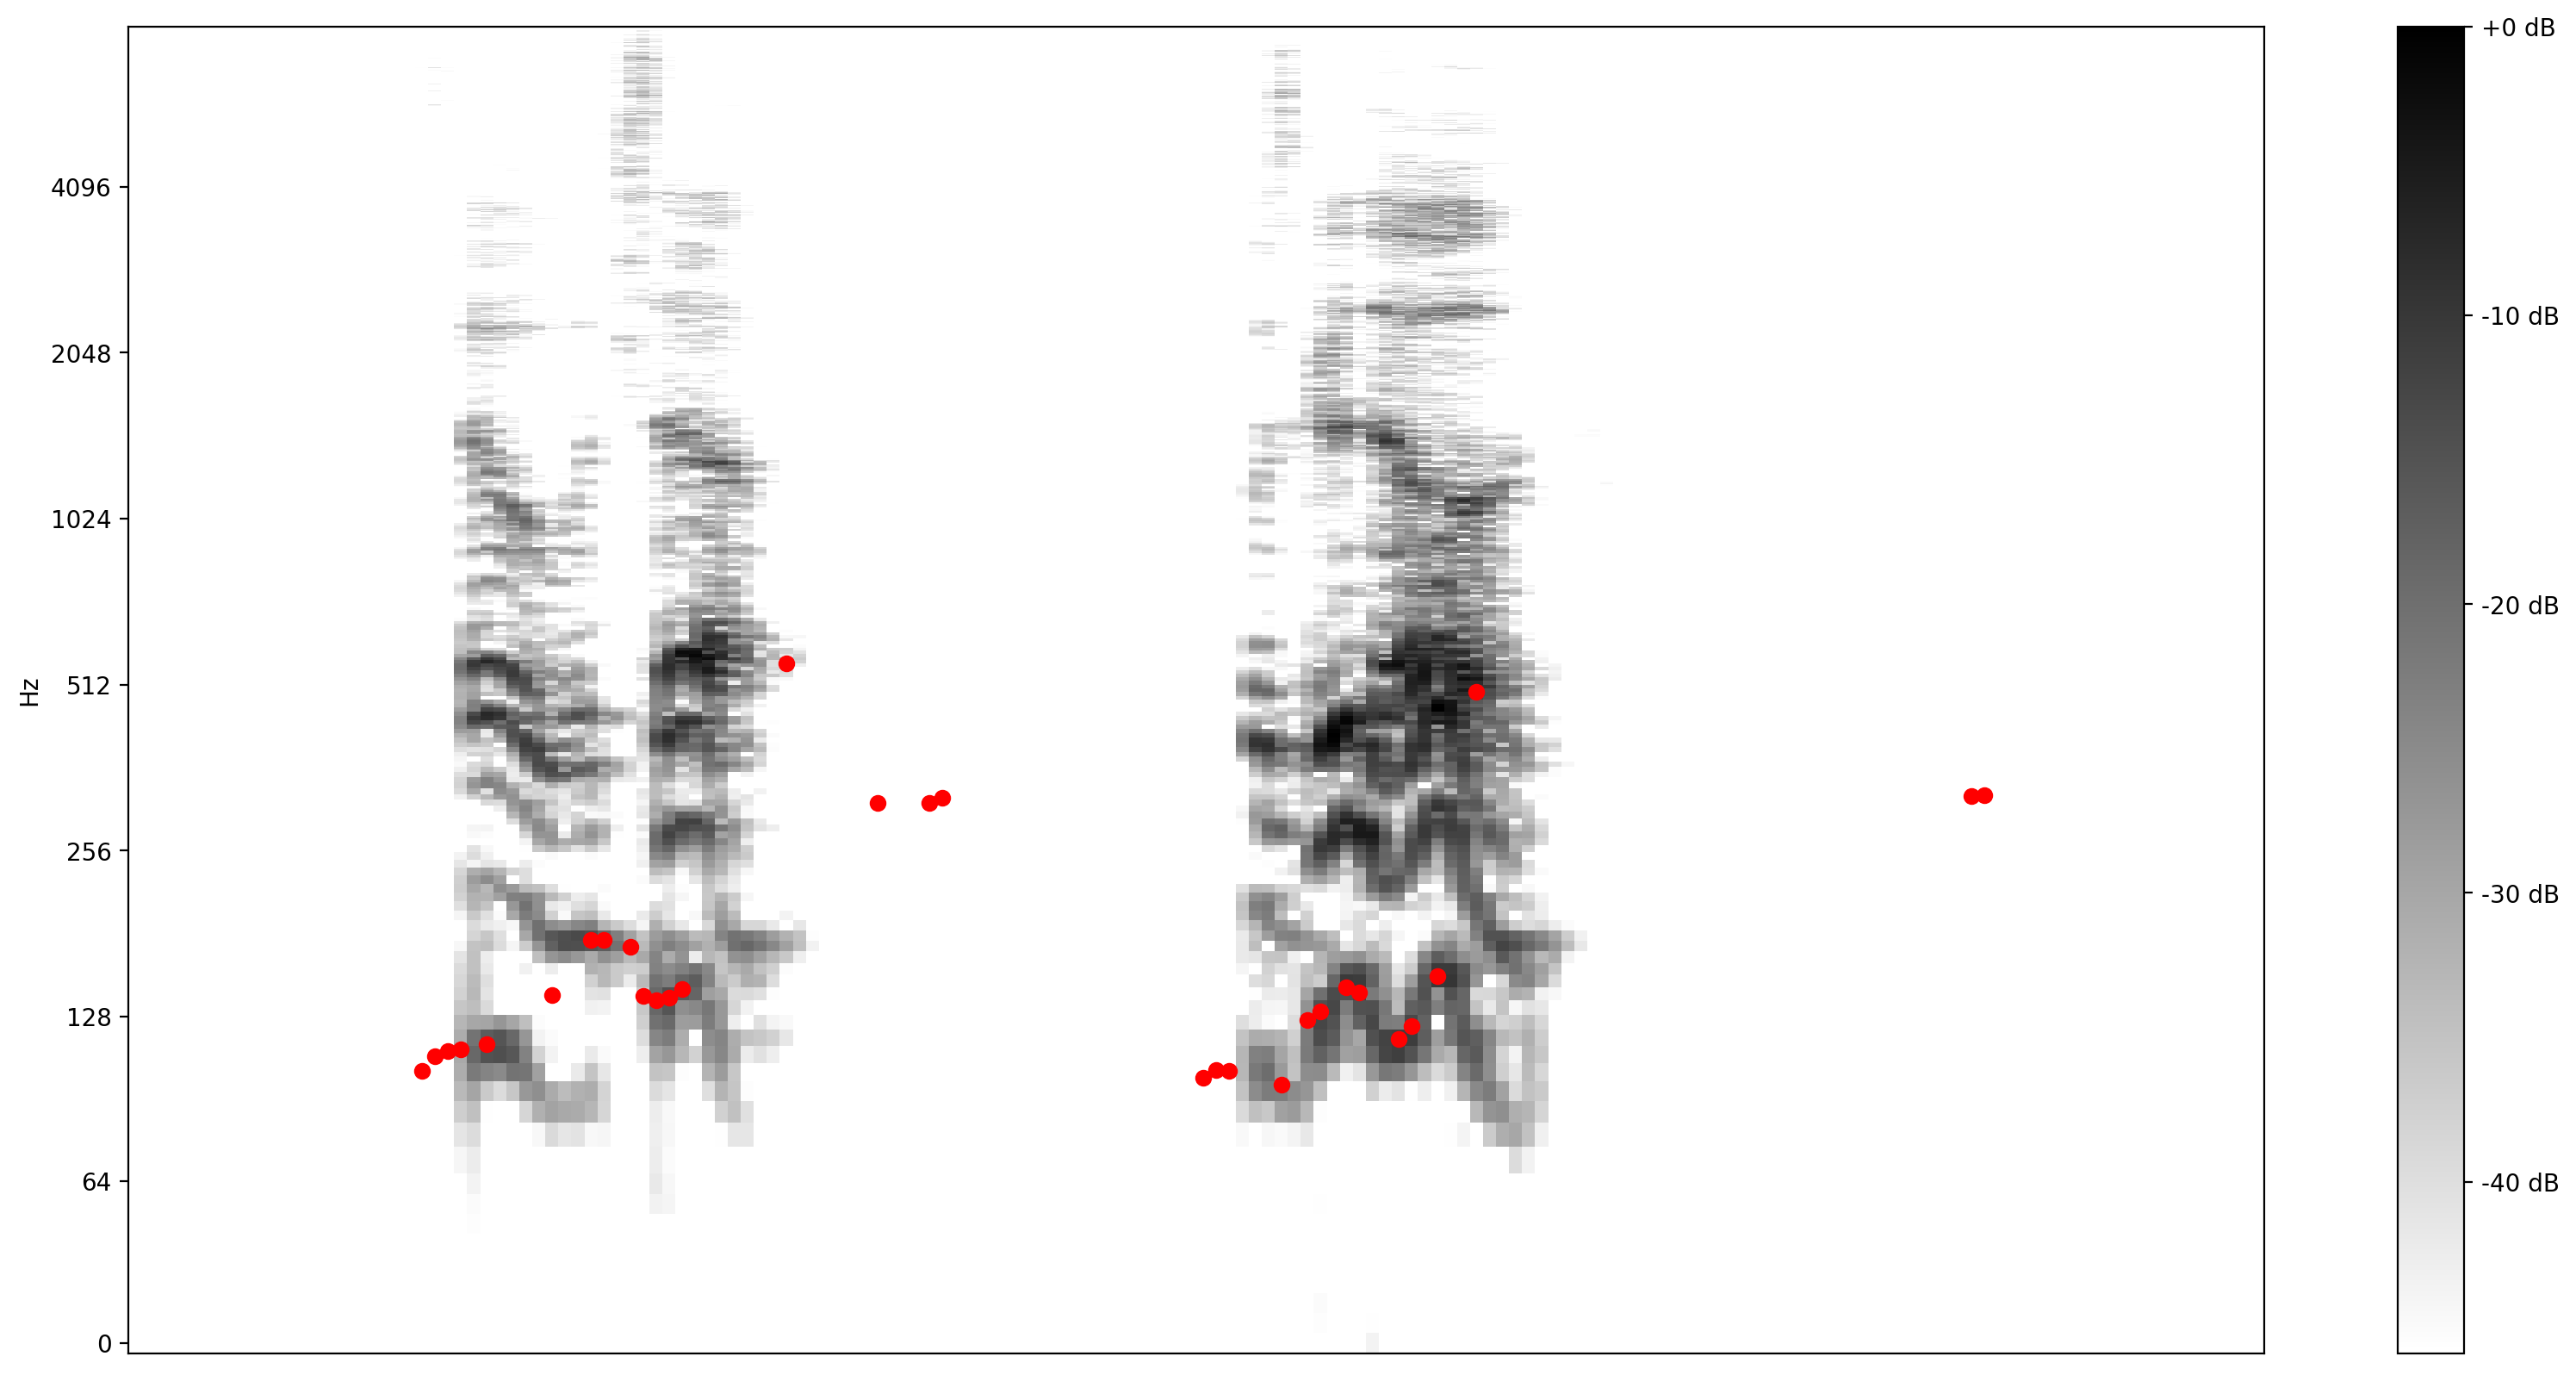

In [15]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

plot_stft(audio_samples / MAX_ABS_INT16 , 
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs 
# also get converted to the log scale automatically by matplotlib.
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

print(audio_samples)

plt.show()

In [16]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]


def hz2offset(freq):
    # This measures the quantization error for a single note.
    if freq == 0:  # Rests always have zero error.
        return None
    # Quantized note.
    h = round(12 * math.log2(freq / C0))
    return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)


def quantize_predictions(group, ideal_offset):
    # Group values are either 0, or a pitch in Hz.
    non_zero_values = [v for v in group if v != 0]
    zero_values_count = len(group) - len(non_zero_values)

    # Create a rest if 80% is silent, otherwise create a note.
    if zero_values_count > 0.8 * len(group):
        # Interpret as a rest. Count each dropped note as an error, weighted a bit
        # worse than a badly sung note (which would 'cost' 0.5).
        return 0.51 * len(non_zero_values), "Rest"
    else:
        # Interpret as note, estimating as mean of non-rest predictions.
        h = round(
            statistics.mean([
                12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
            ]))
        octave = h // 12
        n = h % 12
        note = note_names[n] + str(octave)
        # Quantization error is the total difference from the quantized note.
        error = sum([
            abs(12 * math.log2(freq / C0) - ideal_offset - h)
            for freq in non_zero_values
        ])
        return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
    # Apply the start offset - we can just add the offset as rests.
    pitch_outputs_and_rests = [0] * prediction_start_offset + \
        pitch_outputs_and_rests
    # Collect the predictions for each note (or rest).
    groups = [
        pitch_outputs_and_rests[i:i + predictions_per_eighth]
        for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
    ]

    quantization_error = 0

    notes_and_rests = []
    for group in groups:
        error, note_or_rest = quantize_predictions(group, ideal_offset)
        quantization_error += error
        notes_and_rests.append(note_or_rest)

    return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
    for prediction_start_offset in range(predictions_per_note):

        error, notes_and_rests = get_quantization_and_error(
            pitch_outputs_and_rests, predictions_per_note,
            prediction_start_offset, ideal_offset)

        if error < best_error:
            best_error = error
            best_notes_and_rests = notes_and_rests
            best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
    best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
    best_notes_and_rests = best_notes_and_rests[:-1]

    # Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0, a)

for snote in best_notes_and_rests:
    d = 'half'
    if snote == 'Rest':
        sc.append(music21.note.Rest(type=d))
    else:
        sc.append(music21.note.Note(snote, type=d))



offsets:  [0.0916666971271809, 0.24578716175014392, -0.17498097016159875, 0.07359366731103023, 0.4506216265385916, -0.24668331353608863, -0.2853539322191878, 0.359234636587459, -0.008099869328184184, 0.33227356569225464, -0.007756273883025244, -0.469199463861635]
ideal offset:  0.030091961001411722


IndexError: list index out of range